In [196]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.animation import FuncAnimation
from IPython.display import HTML



In [197]:
def plot_particle_positions(positions, sigma, box_size):
    """
    Plots the positions of particles with circles representing their radii.

    Parameters:
    positions (numpy.ndarray): An Nx2 array of particle positions.
    sigma (float): The diameter of the particles.
    box_size (float): The size of the simulation box (assumed square in 2D).
    """
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot each particle as a circle
    for pos in positions:
        circle = plt.Circle((pos[0], pos[1]), sigma / 2, color='blue', fill=False, linewidth=2)
        ax.add_patch(circle)
    
    # Set the limits and aspect of the plot to match the simulation box size
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    ax.set_aspect('equal', adjustable='box')
    
    # Add labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Particle Positions with Radii')
    
    # Display the plot
    plt.show()

In [ ]:
# Parameters and Simulation Setup
N = 224  # Number of particles
box_size = L = 10.0  # Box size
sigma = 0.4  # Particle diameter
n_steps = 500  # Number of steps
delta = 0.1  # Maximum displacement per move
K = 2  # Constant greater than 1
d_0 = 1.0  # Initial separation
m = 1  # Arbitrary value for m
bins = 20
r_max = L / 2  # Max distance for RDF
r_cutoff = 2.5  # Cutoff for distance
rows, cols = 16, 14  # Lattice dimensions

# Function to generate a hexagonal lattice with padding from the edges
def generate_hexagonal_lattice_padded(N, L, sigma, rows=16, cols=14):
    """
    Generates a hexagonal lattice of particles, with padding to ensure that no part of the particle
    leaves the box (all particles are at least sigma / 2 distance away from the box edges).
    
    Parameters:
    N (int): Number of particles.
    L (float): Size of the box.
    sigma (float): Diameter of the particles.
    rows (int): Number of rows in the lattice.
    cols (int): Number of columns in the lattice.

    Returns:
    numpy.ndarray: Positions of the particles.

    """
    # Ensure we don't exceed N particles
    N = min(N, rows * cols)

    # List to store the positions of the particles
    positions = []

    # Horizontal spacing (sigma) and vertical spacing (sqrt(3)/2 * sigma) for hexagonal packing
    dx = sigma
    dy = np.sqrt(3) * sigma / 2

    # Define the valid range for the particle centers (to ensure no part is out of bounds)
    padding = sigma / 2
    x_min, x_max = padding, L - padding
    y_min, y_max = padding, L - padding

    for i in range(rows):
        for j in range(cols):
            if len(positions) < N:
                # Horizontal offset for odd rows (shift by sigma/2)
                x = j * dx + padding
                y = i * dy + padding

                if j % 2 == 1:  # Offset every other row (odd rows)
                    y += dy / 2

                # Ensure the particles are within bounds
                if x_min <= x <= x_max and y_min <= y <= y_max:
                    positions.append([x, y])
    
    # Convert positions to numpy array
    positions = np.array(positions)

    # Apply periodic boundary conditions (if needed)
    positions[:, 0] %= L
    positions[:, 1] %= L

    return positions

# Initialize particle positions using the hexagonal lattice
positions = generate_hexagonal_lattice_padded(N, box_size, sigma)


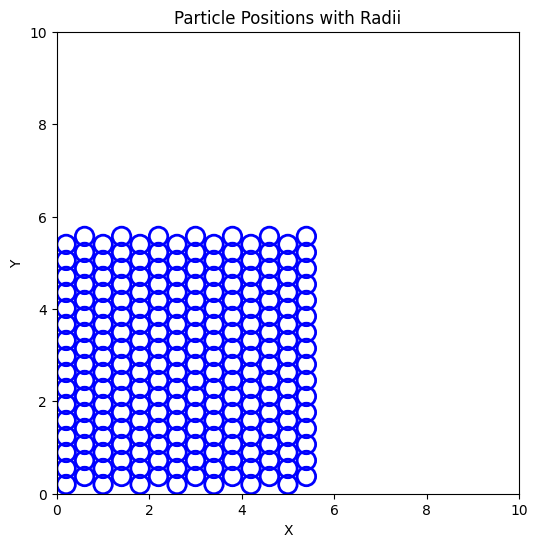

In [199]:
plot_particle_positions(positions, sigma, box_size)

In [200]:
# Compute the radial distribution function (RDF)
def compute_rdf(positions, L, sigma, bins, r_max):
    distances = []
    N = len(positions)
    
    for i in range(N):
        for j in range(i+1, N):
            # Calculate distance between particles i and j with periodic boundary conditions
            dx = positions[i, 0] - positions[j, 0]
            dy = positions[i, 1] - positions[j, 1]
            dx -= np.round(dx / L) * L  # Apply periodic boundary
            dy -= np.round(dy / L) * L  # Apply periodic boundary
            r = np.sqrt(dx**2 + dy**2)
            if r < r_max:
                distances.append(r)

    # Calculate RDF
    hist, edges = np.histogram(distances, bins=bins, range=(0, r_max), density=True)
    r = 0.5 * (edges[1:] + edges[:-1])  # Calculate the center of each bin
    g_r = hist * (4 * np.pi * r**2)  # Radial distribution function formula

    return r, g_r

# Calculate N_m based on the condition from the paper
def compute_N_m(positions, L, K, d_0, m):
    N = len(positions)
    N_m = 0  # Initialize the number of pairs satisfying the condition

    # Calculate DeltaA
    Delta_A = ((K**2 - 1) * np.pi * d_0**2) / 64

    for i in range(N):
        for j in range(i + 1, N):
            dx = positions[i, 0] - positions[j, 0]
            dy = positions[i, 1] - positions[j, 1]
            dx -= np.round(dx / L) * L  # Periodic boundary
            dy -= np.round(dy / L) * L  # Periodic boundary
            r = np.sqrt(dx**2 + dy**2)

            # Calculate the left and right bounds based on the inequality
            left_bound = (1 - m)**2 * Delta_A**2 + np.pi * d_0**2
            middle = np.pi * (r ** 2)
            right_bound = m * Delta_A**2 + np.pi * d_0**2
            print(left_bound, middle, right_bound)
            

            # Check if the distance r satisfies the inequality for N_m
            if left_bound <= middle <= right_bound:
                N_m += 1

    return N_m

# Metropolis algorithm to update positions
def metropolis(positions, L, sigma, delta, r_cutoff, K, d_0, m):
    N = len(positions)
    i = random.randint(0, N-1)
    old_pos = positions[i].copy()

    # Propose a random displacement
    displacement = np.random.uniform(-delta, delta, size=2)
    new_pos = old_pos + displacement

    # Apply periodic boundary conditions
    new_pos = new_pos % L

    # Compute energy change (just based on overlap for hard spheres)
    energy_old = 0
    energy_new = 0
    for j in range(N):
        if i != j:
            # Calculate distance between particles i and j
            dx = new_pos[0] - positions[j, 0]
            dy = new_pos[1] - positions[j, 1]
            dx -= np.round(dx / L) * L  # Periodic boundary
            dy -= np.round(dy / L) * L  # Periodic boundary
            r = np.sqrt(dx**2 + dy**2)
            if r < sigma:
                energy_new += 1
            dx = old_pos[0] - positions[j, 0]
            dy = old_pos[1] - positions[j, 1]
            dx -= np.round(dx / L) * L  # Periodic boundary
            dy -= np.round(dy / L) * L  # Periodic boundary
            r = np.sqrt(dx**2 + dy**2)
            if r < sigma:
                energy_old += 1

    # Acceptance criterion (Metropolis criterion)
    dE = energy_new - energy_old
    if dE <= 0 or random.random() < np.exp(-dE):
        positions[i] = new_pos  # Accept the move
    else:
        positions[i] = old_pos  # Reject the move

    # Track N_m
    N_m = compute_N_m(positions, L, K, d_0, m)

    return N_m

# Main simulation loop
def run_simulation(L, sigma, delta, r_cutoff, K, d_0, m, n_steps, bins, r_max):
    # Initialize positions (replace this with your initialization function)
    N = 100  # Example number of particles
    positions = np.random.uniform(0, L, (N, 2))

    rdf_list = []  # To store the RDF at each step
    positions_list = []  # To store positions at each step
    N_m_list = []  # To store the value of N_m at each step

    for step in range(n_steps):
        # Perform Metropolis update and track N_m
        N_m = metropolis(positions, L, sigma, delta, r_cutoff, K, d_0, m)
        
        # Track N_m every 10 steps
        if step % 10 == 0:
            r, g_r = compute_rdf(positions, L, sigma, bins, r_max)
            rdf_list.append(g_r)
            positions_list.append(positions)
            N_m_list.append(N_m)
            print(f"Step {step}, N_m = {N_m}, Positions shape: {positions.shape}")
    
    # Plot the RDF at different steps
    plt.figure(figsize=(8, 6))
    for i, g_r in enumerate(rdf_list):
        plt.plot(r, g_r, label=f"Step {i*10}")
    plt.xlabel("r (distance)")
    plt.ylabel("g(r) (RDF)")
    plt.title("Radial Distribution Function over Time")
    plt.legend()
    plt.show()

    # Plot N_m over time
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(0, n_steps, 10), N_m_list, marker='o', color='r')
    plt.xlabel("Step")
    plt.ylabel("N_m (Number of pairs satisfying the condition)")
    plt.title("Tracking N_m over Time")
    plt.show()

    return rdf_list, positions_list, N_m_list


rdf_list, positions_list, N_m_list = run_simulation(L, sigma, delta, r_cutoff, K, d_0, m, n_steps, bins, r_max)


3.142533892412834 12.239742537257888 3.143475131235875
3.142533892412834 54.296960091978804 3.143475131235875
3.142533892412834 33.427105352773765 3.143475131235875
3.142533892412834 80.9201462910068 3.143475131235875
3.142533892412834 4.237462086882192 3.143475131235875
3.142533892412834 72.16923175218915 3.143475131235875
3.142533892412834 35.74356691092111 3.143475131235875
3.142533892412834 78.36797211001799 3.143475131235875
3.142533892412834 137.93168219042815 3.143475131235875
3.142533892412834 93.09981431402758 3.143475131235875
3.142533892412834 89.33493909168317 3.143475131235875
3.142533892412834 146.3792944928409 3.143475131235875
3.142533892412834 18.86364875219746 3.143475131235875
3.142533892412834 35.29832602070567 3.143475131235875
3.142533892412834 43.96122416832316 3.143475131235875
3.142533892412834 51.35123065256666 3.143475131235875
3.142533892412834 36.01622380089717 3.143475131235875
3.142533892412834 36.22296555569208 3.143475131235875
3.142533892412834 93.0418

KeyboardInterrupt: 

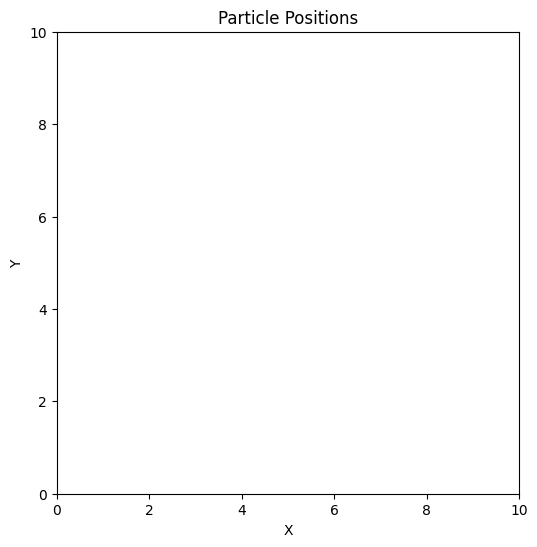

In [ ]:
def plot_particle_positions_animation(positions_list, sigma, box_size, interval=200):
    """
    Create an animation of particle positions with the given parameters.

    Parameters:
    positions_list (list of np.ndarray): List of particle positions (Nx2 arrays).
    sigma (float): Diameter of particles (used to define their size in the plot).
    box_size (float): The size of the simulation box (assumed square in 2D).
    interval (int): Interval between frames in milliseconds.
    """
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Particle Positions')

    # Initialize the scatter plot with no data yet
    scatter = ax.scatter([], [], s=(sigma**2), color='blue', edgecolors='black', linewidths=1)

    def init():
        """Initialize the background of the animation."""
        scatter.set_offsets([])  # Empty set of points initially
        return scatter,

    def update(frame):
        """Update the particle positions for each frame."""
        current_positions = positions_list[frame]

        # Ensure current_positions is a 2D array (Nx2)
        if current_positions.ndim != 2 or current_positions.shape[1] != 2:
            current_positions = np.array(current_positions).reshape(-1, 2)  # Reshape to (N, 2)

        # Update the scatter plot with the new positions
        scatter.set_offsets(current_positions)

        return scatter,

    # Create the animation without blit (for simplicity)
    anim = FuncAnimation(fig, update, frames=len(positions_list), init_func=init, interval=interval)

    # Display the animation
    plt.show()

    return anim


animation = plot_particle_positions_animation(positions_list, sigma, box_size, interval=200)


In [ ]:
HTML(animation.to_jshtml())


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
print(positions_list)

[array([[0.2       , 0.2       ],
       [0.6       , 0.37320508],
       [0.98773206, 0.1744955 ],
       [1.4       , 0.37320508],
       [1.78873342, 0.16209636],
       [2.2       , 0.37320508],
       [2.63106425, 0.19794143],
       [3.        , 0.37320508],
       [3.4       , 0.2       ],
       [3.8       , 0.37320508],
       [4.31212532, 0.16268828],
       [4.6       , 0.37320508],
       [5.        , 0.2       ],
       [5.4       , 0.37320508],
       [0.2       , 0.54641016],
       [0.6       , 0.71961524],
       [1.        , 0.54641016],
       [1.4       , 0.71961524],
       [1.86459647, 0.58419078],
       [2.2       , 0.71961524],
       [2.60518656, 0.47979135],
       [3.        , 0.71961524],
       [3.4       , 0.54641016],
       [3.76439652, 0.67250351],
       [4.18806826, 0.49273713],
       [4.55850044, 0.63822689],
       [5.        , 0.54641016],
       [5.38685344, 0.73882791],
       [0.2       , 0.89282032],
       [0.6       , 1.0660254 ],
       [1